# Set up & install

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg
!wget https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names

--2023-06-27 16:03:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  45.3MB/s    in 5.6s    

2023-06-27 16:03:50 (42.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-06-27 16:03:50--  https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg
Resolving opencv-tutorial.readthedocs.io (opencv-tutorial.readthedocs.io)... 104.17.32.82, 104.17.33.82, 2606:4700::6811:2052, ...
Connecting to opencv-tutorial.readthedocs.io (opencv-tutorial.readthedocs.io)|104.17.32.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8341 (8.1K) [application/octet-stream]
Saving to: ‘yolov3.cfg’

yolov3.cfg         

In [4]:
# Load YOLOv3 weights and configuration
network = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
layers = network.getLayerNames()
output_layers = [layers[i - 1] for i in network.getUnconnectedOutLayers()]

# Load classes
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Load video
video_path = 'Intersection.mp4'
cap = cv2.VideoCapture(video_path)

# Run detections

In [6]:
# Run YOLO detection on each frame
frame_id = 0
output_data = []
while cap.isOpened():
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        break
    frame_id += 1
    height, width, channels = frame.shape

    # Detect objects in the frame
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    network.setInput(blob)
    outs = network.forward(output_layers)

    # Process the detections
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Minimum confidence threshold
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Bounding box coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # Store the detections for this frame
    frame_data = {
        'frame_id': frame_id,
        'detections': []
    }

    # Append the detection information to frame_data
    for i in range(len(boxes)):
        class_id = class_ids[i]
        confidence = confidences[i]
        label = classes[class_id]
        box = boxes[i]

        detection_info = {
            'class': label,
            'bounding_box': box,
            'confidence': confidence
        }
        frame_data['detections'].append(detection_info)

    output_data.append(frame_data)

In [9]:
# Save the output data to a JSON file
output_file = 'gdrive/MyDrive/Application/Data/Requirement1b/output_data.json'
with open(output_file, 'w') as f:
    json.dump(output_data, f)

# Release resources
cap.release()
cv2.destroyAllWindows()

# Check the results

In [10]:
print('Sample output data:')
output_data[0]

Sample output data:


{'frame_id': 1,
 'detections': [{'class': 'bus',
   'bounding_box': [955, 270, 137, 60],
   'confidence': 0.737694263458252},
  {'class': 'bus',
   'bounding_box': [952, 269, 171, 65],
   'confidence': 0.528350830078125},
  {'class': 'car',
   'bounding_box': [694, 306, 48, 39],
   'confidence': 0.655228853225708},
  {'class': 'car',
   'bounding_box': [689, 318, 56, 33],
   'confidence': 0.6027601957321167},
  {'class': 'car',
   'bounding_box': [1616, 327, 113, 45],
   'confidence': 0.6922821402549744},
  {'class': 'car',
   'bounding_box': [467, 347, 64, 32],
   'confidence': 0.5183164477348328},
  {'class': 'car',
   'bounding_box': [1097, 349, 69, 33],
   'confidence': 0.8976473808288574},
  {'class': 'car',
   'bounding_box': [1162, 344, 88, 33],
   'confidence': 0.9492598176002502},
  {'class': 'car',
   'bounding_box': [1160, 341, 95, 38],
   'confidence': 0.6890349388122559},
  {'class': 'car',
   'bounding_box': [1295, 343, 90, 32],
   'confidence': 0.7283030152320862},
  {'c

Sample detections:


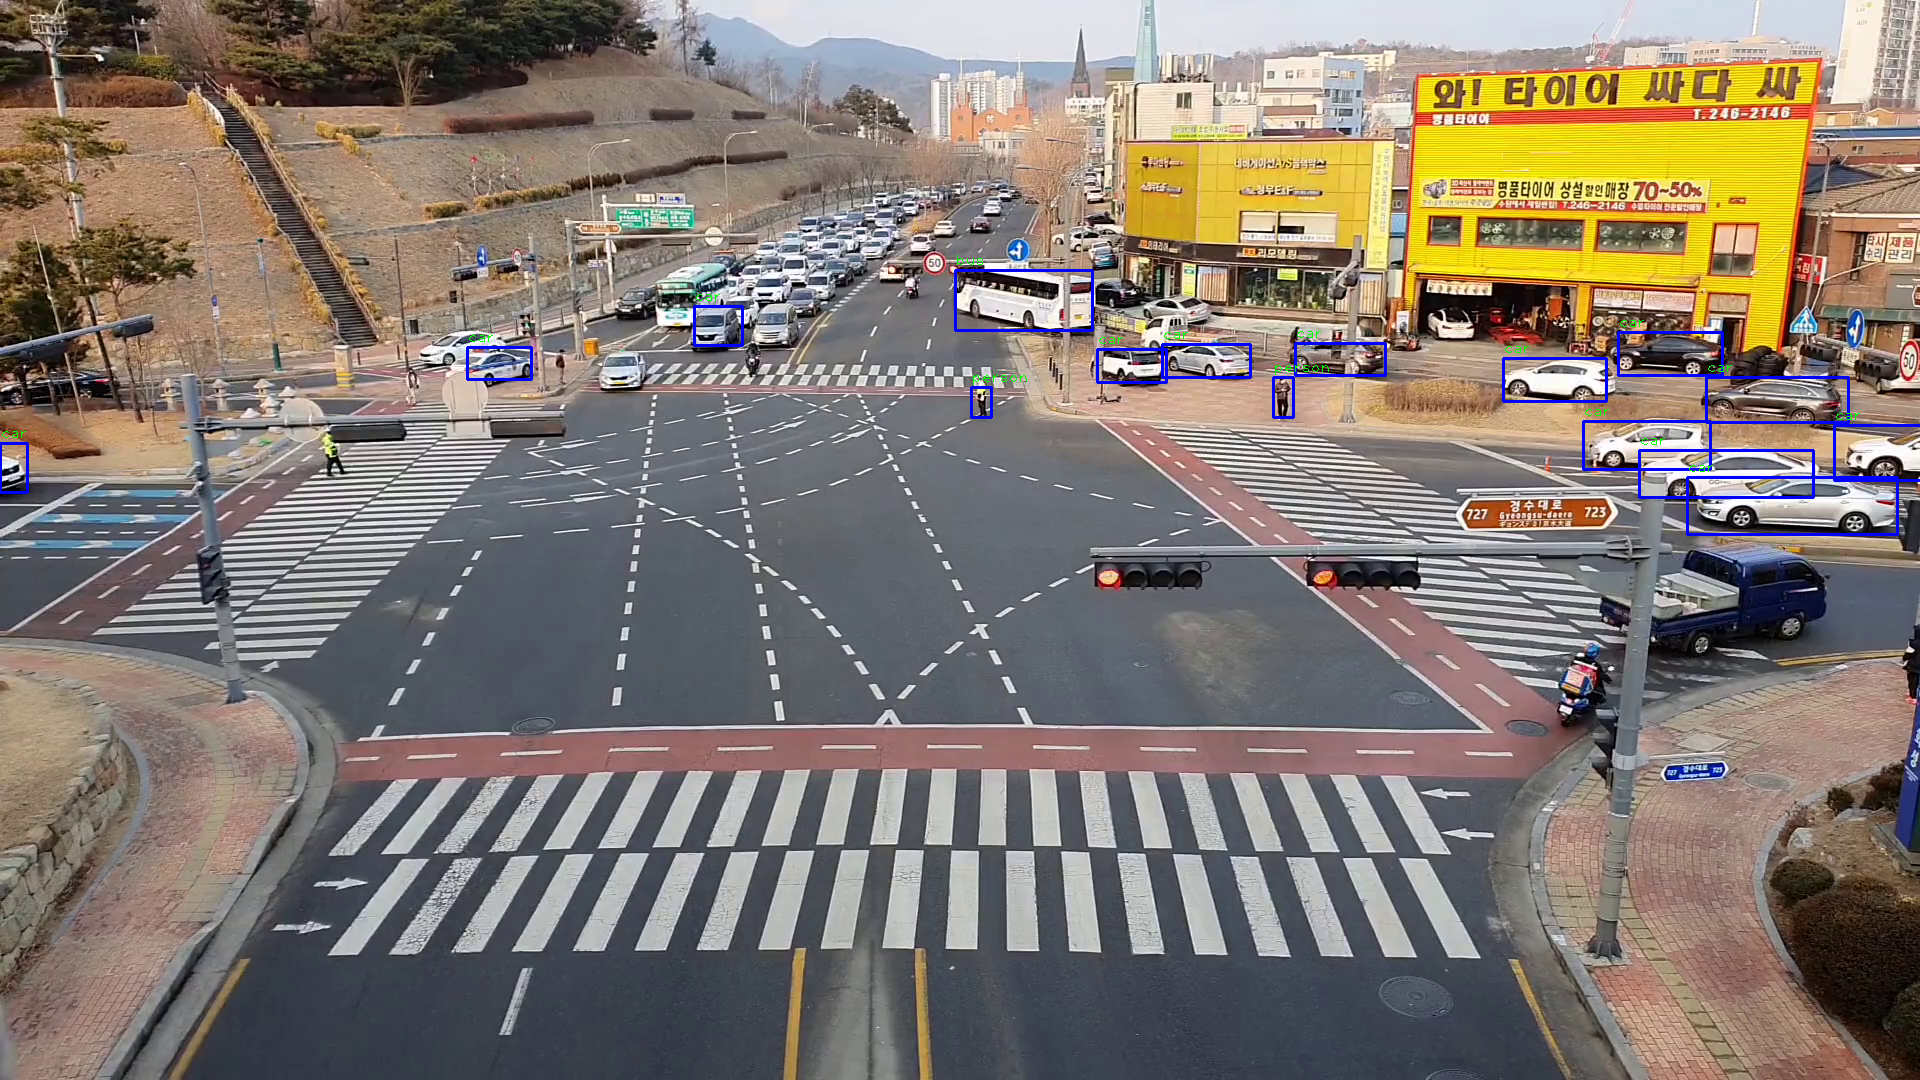

In [11]:
def get_output_info(outputs, frame_id):
  for out in outputs:
    if out['frame_id'] == frame_id:
      return out['detections']


def draw_labels(img, detections):
  font = cv2.FONT_HERSHEY_PLAIN

  detections = list(detections)
  confidences = [d['confidence'] for d in detections]
  boxes = [d['bounding_box'] for d in detections]
  classes = [d['class'] for d in detections]
  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
      cv2.putText(img, classes[i], (x, y - 5), font, 1, (0, 255, 0), 1)


print('Sample detections:')
detections = get_output_info(output_data, frame_id=1)
cap = cv2.VideoCapture(video_path)
ret, img = cap.read()
draw_labels(img, detections)
cv2_imshow(img)